<a href="https://colab.research.google.com/github/Ashitha11/Langgraph/blob/main/LanggraphwithTools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

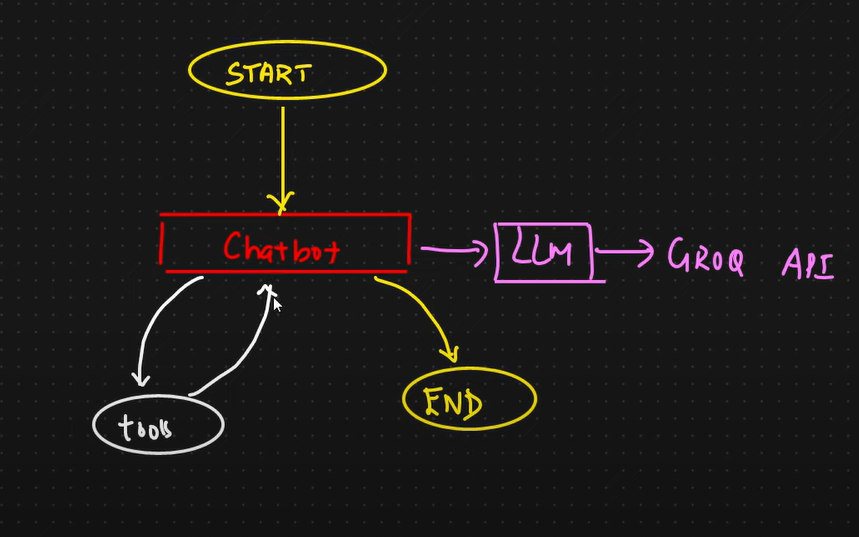

In [2]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [3]:
!pip install python-dotenv
!pip install arxiv wikipedia

In [4]:
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
import os

In [5]:
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_TRACING_V2 = os.getenv("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = os.getenv("LANGCHAIN_ENDPOINT")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")

In [6]:
##working with tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper = api_wrapper)

In [7]:
wiki_tool.invoke("Who is Satoshi nakamoto?")

"Page: Satoshi Nakamoto\nSummary: Satoshi Nakamoto  is the name used by the presumed pseudonymous person or persons who developed bitcoin, authored the bitcoin white paper, and created and deployed bitcoin's original reference implementation. As part of the implementation, Nakamoto also devised the fi"

In [8]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [13]:
tools = [wiki_tool]
print(tools)

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.11/dist-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=300))]


In [14]:
##Langgraph application
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

#STATE CLASS
class State(TypedDict):
  messages:Annotated[list,add_messages]

#CHATBOT/WORKFLOW
graph_builder = StateGraph(State)
llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name ="Gemma2-9b-It")

llm_with_tools = llm.bind_tools(tools=tools)

def chatbot(state:State):
  return {"messages":llm_with_tools.invoke(state["messages"])}

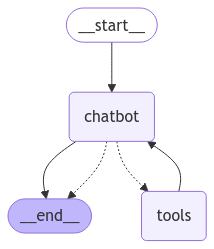

In [15]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node("chatbot",chatbot)                                   #chatbot node created
graph_builder.add_edge(START,"chatbot")                                     #START goes to chatbot

##tool_node = this node represents a collection of tools that the AI agent can use.
##tools parameter is a list of functions or API tools that the agent can call.
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)                                   # tool node is created
graph_builder.add_conditional_edges(                                        #this conditional edges must be used when workflow is bidirectional
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

##to display the graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

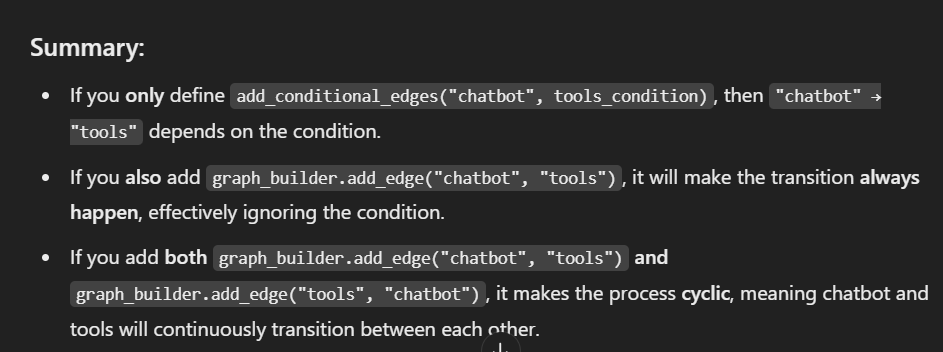

In [20]:
user_input = "Hi there, My name is Nisha"
events = graph.stream(
    {"messages":[("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there, My name is Nisha
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_q80s)
 Call ID: call_q80s
  Args:
    query: Nisha


/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

Page: Nisha Katona
Summary: Nisha Katona, MBE (born 23 October 1971) is a British restaurateur and TV personality. The daughter of two doctors, she is the founder of Mowgli Street Food restaurants and the Mowgli Trust charity, a food writer and  television presenter. She was a child protection barri
================================== Ai Message ==================================

That's interesting!  I'm just a language model, not a person.
